# Example 2: R$_{1\rho}$ Relaxation under MAS

In [1]:
#!!pip install git+https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

## Build the spin system
For relaxation induced by exchange, we always build the spin system with at least two different sets of interactions. Not all interactions must change, but at least one interaction should be different– otherwise no relaxation will occure. Note that best-practice is to build the first spin-system, and copy it and only edit the parameters that are changed in the second spin-system.

pyRelaxSim takes the main experimental parameters (excepting rf fields) upon initialization of a spin-system, and then interactions are added afterwards.

In [2]:
ex0=RS.ExpSys(v0H=600,vr=45000,Nucs=['13C','1H'])     #1-spin system at 600 MHz (14.1 T)
delta=RS.Tools.dipole_coupling(.109,'1H','13C')
ex0.set_inter(Type='dipole',i0=0,i1=1,delta=delta)    #Dipole coupling
ex1=ex0.copy()   #Copies the spin-system
ex1.set_inter(Type='dipole',i0=0,i1=1,delta=delta,euler=[0,30*np.pi/180,0])   #30 degree hop of dipole coupling

## Define Liouvillian, pulse sequence, initial density operator, detection operator

In [16]:
L=RS.Liouvillian((ex0,ex1))  #Liouvillian with both Hamiltonians
seq=RS.Sequence(L)
seq.add_channel('13C',v1=44000) #Constant field (25 kHz) applied
rho=RS.Rho(rho0='13Cx',detect='13Cx',L=L)   #Specify by Nucleus type and operator type

## Calculate time-trace as a function of correlation time

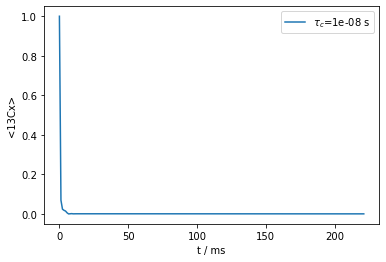

In [17]:
tc0=np.logspace(-8,-3,6)   #Correlation time axis
fig=plt.figure()
ax=fig.add_subplot(111)  #Axis for plotting results
for tc in tc0[3:4]:
    L.kex=[[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]]
    U=seq.U()**50  #Propagator for 50 rotor periods (L.U() returns 1 rotor period, **50 raises it to 50 rotor periods)
    
    rho.clear()  #Clear all information out of rho
    rho.DetProp(U,n=200)  #Detect and then apply propagator 100 times (so 5000 rotor cycles)
    rho.plot(ax=ax)
ax.legend([r'$\tau_c$='+f'{tc:.0e} s' for tc in tc0],loc='upper right')
    

## Calculate R$_{1\rho}$ profile as a function of the applied field strength

In [14]:
tc0=np.logspace(-7,-4,4)
v10=np.linspace(0,45000,21)
R1p=list()  #Collect R1p results
for tc in tc0:
    R1p.append(list())
    for v1 in v10:
        seq.add_channel('13C',v1=v1)
        L.kex=[[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]]
        U=seq.U()  #Propagator for 10 rotor periods
        
        rho.clear()  #Clear rho
        R1p[-1].append(rho.extract_decay_rates(U,pwdavg=True))
R1p=np.array(R1p)

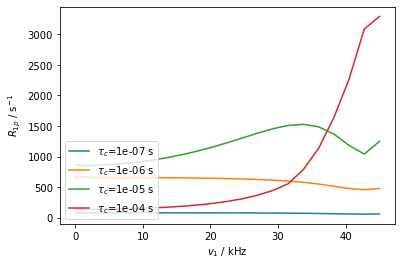

In [15]:
ax=plt.figure().add_subplot(111)
for R1p0 in R1p:
    ax.plot(v10/1e3,R1p0)
ax.set_xlabel(r'$v_1$ / kHz')
ax.set_ylabel(r'$R_{1\rho}$ / s$^{-1}$')
ax.legend([r'$\tau_c$='+f'{tc:.0e} s' for tc in tc0],loc='lower left')